# KHS cluster analysis with Word2Vec

@hyyoka


---

본 포스트는 freq 실습에서도 이용했던 Korean Hate Speech 데이터셋으로 진행하였다. 해당 데이터셋을 이용한 이유는 혐오표현들과 비혐오표현들이 cluster를 이루는지 확인하기 위함이다. 

시기별로 구분한다면, 특정 어휘가 의미적 변화를 겪으면서 혐오의 뜻을 가지게 되는 것 확인할 수 있다. 반대의 방향이라면 더욱 심각하다. 언어에는 내재된 사상들이 있다. 즉, 혐오표현이라고 생각하지 않았지만 사실은 기저에 그러한 의미를 담고있을 가능성이 크다는 것을 의미하며 이는 재검토가 필요하다고 할 수 있다. 

따라서, 이번 실습을 통해 확인하고자 하는 것은 다음과 같다:
1. 혐오표현들이 클러스터를 형성하는가
2. 해당 클러스터에 속한 비혐오표현이 있는가 

만약 혐오단어 클러스터에 비혐오표현이 속해있다면, 그 단어를 재검토하는 것을 목적으로 한다. 한 시기만을 대상으로 하기에, 역사언어학적 분석은 불가능하지만 현재 내재된 혐오가 조금이라도 있는지 확인할 수는 있다. 물론, Word2vec은 분포가설에 근거하기에 클러스터에 속한다고해서 무조건 혐오를 내재하는 것은 아니다. 

본인은 다음을 믿는다:
- Word change World change

단어의 사용은 화자의 사상에 큰 영향을 끼친다. 따라서 평소 일반인들이 사용하는 단어들에 대한 고찰이 필요하다. 

##데이터 준비

In [ ]:
# okt tokenizer를 사용하기 위한 konlpy 설치

!pip install konlpy

In [ ]:
# 필요한 모듈 임포트

import requests
import re
import pandas as pd
from collections import Counter
from konlpy.tag import Okt

In [ ]:
# 데이터 확인

df = pd.read_csv('/content/train.tsv', sep="\t")
df

,comments,contain_gender_bias,bias,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate
...,...,...,...,...
7891,힘내세요~ 응원합니다!!,False,none,none
7892,힘내세요~~삼가 고인의 명복을 빕니다..,False,none,none
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,False,none,none
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,False,none,none


In [ ]:
# bias를 담고있지 않은 데이터들의 수 확인: 5147

pd.DataFrame(list(df[df['bias']=='none']['comments']))

,0
0,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...
1,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래..."
2,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데"
3,10+8 진짜 이승기랑 비교된다
4,10년뒤 윤서인은 분명히 재평가될것임. 말하나하나가 틀린게없음
...,...
5143,힘내세요~ 응원합니다!!
5144,힘내세요~~삼가 고인의 명복을 빕니다..
5145,힘내세용 ^^ 항상 응원합니닷 ^^ !
5146,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...


bias를 담고 있지 않은 데이터의 수가 훨씬 많다는 것을 확인했다. 

In [ ]:
# 데이터 중 comments만을 대상으로 한다.

data_bf = list(df['comments'])

## 데이터 전처리

해당 데이터는 인터넷에서 크롤링해서 가져온 것으로, 문법 및 띄어쓰기에 심각한 오류들이 있었으며, 이모지들이 많이 포함되어있었다. 따라서 간단한 전처리 및 정규화 과정을 거쳤다.

In [ ]:
FILTERS = "([~,!?\"':.;~)^(])"
CHANGE_FILTER = re.compile(FILTERS)

EXP = "[ㅋㅎㄷㅉ♡✔️ㅠㅜ1234567890\-]"
CHANGE_EXP = re.compile(EXP)

In [ ]:
tokenizer = Okt()

tokenizer로 okt를 사용한 이유는 정규화 기능이 있기 때문이다. Okt는 stem=True, norm=True의 파라미터가 존재해서, 단어들을 정규화해주고 오타도 수정해준다. 


In [ ]:
words = []
for line in data_bf:
    line = CHANGE_FILTER.sub("", line)
    line = CHANGE_EXP.sub("", line)
    token = tokenizer.morphs(line, stem=True, norm=True)
    words+=token

###Word2Vec Skip-gram 모델 학습
-파이썬 gensim 패키지 활용

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec([words], size=100, sg=1, window=5, min_count=2, iter=100)
print(model)

Word2Vec(vocab=6270, size=100, alpha=0.025)


###임베딩 결과물 확인

In [ ]:
# 전체 단어들 확인
model.wv.vocab.keys()

dict_keys(['현재', '호텔', '주인', '심정', '아', '난', '에', '날벼락', '맞다', '망하다', '생기다', '누', '군', '계속', '추모', '받다', '한국', '적', '인', '미인', '의', '대표', '분', '너무나', '곱', '고', '아름답다', '모습', '그', '뒤', '슬픔', '을', '알다', '하다', '못', '되다', '넘다', '들다', '남', '고통', '즐기다', '들이다', '젠', '마땅하다', '처벌', '래야', '공정하다', '사회', '지', '심다', '거두다', '화', '어설프다', '지나다', '갈수록', '너무', '재밌다', '사람', '얼굴', '손톱', '으로', '긁다', '인격', '살해', '이고', '동영상', '이', '몰카', '냐', '리안', '들', '생각', '없다', '+', '진짜', '이승기', '랑', '비교', '년안', '남녀', '간', '성', '전쟁', '한번', '크게', '후', '일부다처제', '여성', '정치', '참여', '금지', '투표', '권', '삭제', '가', '세계', '문화', '로', '자리', '잡다', '암탉', '울다', '댐', '년뒤', '윤서인', '은', '분명하다', '재', '평가', '임', '말다', '틀리다', '년', '만에', '재미', '를', '느끼다', '프로', '이다', '왜', '니', '때문', '폐지', '방탄', '팬', '인데', '우리', '처럼', '성공', '일단', '이름', '기억', '해', '두다', 'ㅇㅇ', '살', '차이', '부부', '라고', '무슨', '내용', '인지', '네', '월', '이나', '더', '결혼', '기지', '여름', '이라', '비다', '속', '한', '다', '면', '요즘', '세상', '놀라다', '일도', '아니다', '억', '뜯다', '얼마나', '억울', '뒤지다', '아프다', '생인', '울'

In [ ]:
# 유사도 상위 단어 목록 체크
model.wv.most_similar('인격', topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('살해', 0.9867902994155884),
 ('긁다', 0.9809784889221191),
 ('손톱', 0.9309011697769165),
 ('리안', 0.8235002756118774),
 ('교묘하다', 0.7902249097824097)]

In [ ]:
#most_similar를 활용한 단어 관계 확인
#남자 + (여배우 - 배우) = 여자
model.wv.most_similar(positive=['남자', '여배우'], negative=['배우'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('겨우', 0.5977180600166321),
 ('올인', 0.5628964900970459),
 ('박한별', 0.5573159456253052),
 ('달러', 0.5530164241790771),
 ('장미여관', 0.5437453389167786),
 ('혐오', 0.5432896614074707),
 ('길다', 0.5393431186676025),
 ('가장', 0.5389219522476196),
 ('권태기', 0.5382999181747437),
 ('조건', 0.530059814453125)]

해당 공식에 따르면, 정답값은 "여자"가 나와야한다. 하지만 그에 해당하는 결과들에 부정적인 단어들이 많이 속해있다는 것을 확인할 수 있었다. 

##임베딩 시각화

In [ ]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import gensim 
import gensim.models as g

path_nanum = "/content/DXMSubtitlesM-KSCpc-EUC-H.ttf"
prop = fm.FontProperties(fname=path_nanum)
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
freq_list = Counter(words).most_common(800)
vocab = [i[0] for i in freq_list if len(i[0])>1]
X = []
for v in vocab:
    try: X.append(model[v])
    except: continue 

800


전체 단어들 중 가장 빈도가 높았던 800개를 Counter를 이용해 추출하였다. 그 후, 1개의 글자로 이루어진 단어들을 제거하였다. 

In [ ]:
# 시각화 단어 목록 길이
print(len(X))

590


In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

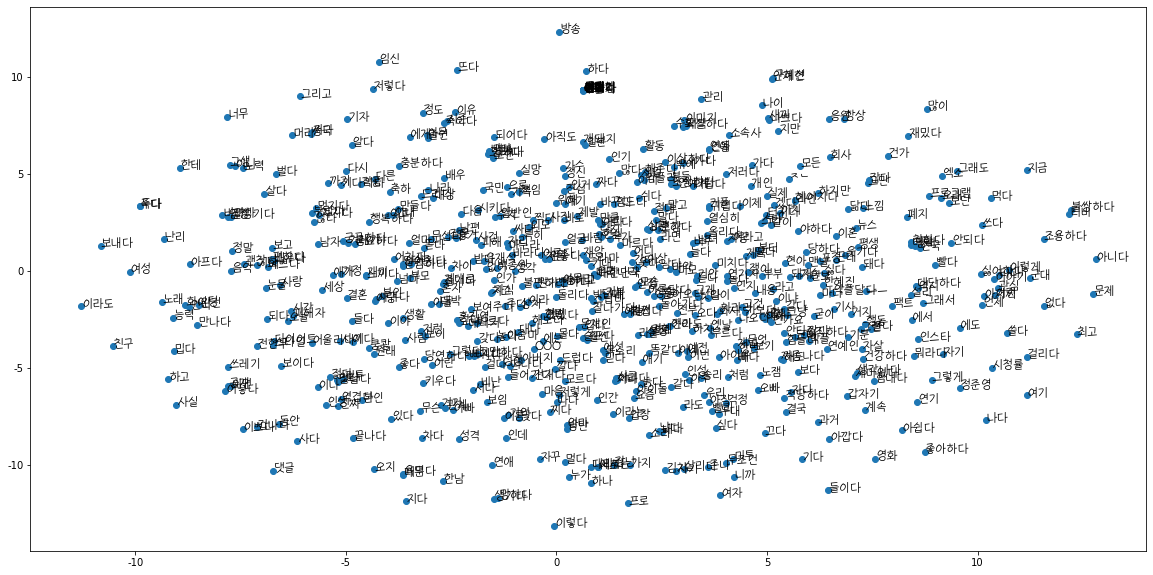

In [ ]:
fig = plt.figure()
fig.set_size_inches(20, 10)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

결론적으로, 두드러지는 클러스터는 형성되지 않았다. 또한 혐오표현들이 한 부근에 꼭 모이지는 않는 것을 확인했다. 

하지만 일반적으로 긍정적인 평가를 받는 "유재석", "백종원"이 모여있고, [싫다, 야하다, 당하다, 기사, 표정] 등의 단어들이 가까운 거리에 위치한다는 것을 확인했다. 

본인은 혐오 클러스터가 형성되지 않은 이유를 코퍼스의 문제라고 생각한다. 사용한 코퍼스의 크기가 지나치게 작았으며, bias와 none의 균형이 맞지 않았기 때문이다. 

만약 큰 사이즈, 그리고 균형이 잡힌 코퍼스로 임베딩을 진행한다면 보다 유의미한 결과가 나올 것으로 기대된다. 
